<a href="https://colab.research.google.com/github/codelspak/Codelion_weekly_projects/blob/main/WK27_Mini_project_Kaggle_ML_Classification_Spaceship_Titanic.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 프로젝트 설명<br>
The Spaceship Titanic was an interstellar passenger liner launched a month ago. With almost 13,000 passengers on board, the vessel set out on its maiden voyage transporting emigrants from our solar system to three newly habitable exoplanets orbiting nearby stars.<br>
<br>
1. PassengerId - A unique Id for each passenger. 
<br>Each Id takes the form gggg_pp where gggg indicates a group the passenger is travelling with and pp is their number within the group. <br>People in a group are often family members, but not always.
2. HomePlanet - The planet the passenger departed from, typically their planet of permanent residence.
3. CryoSleep - Indicates whether the passenger elected to be put into suspended animation for the duration of the voyage. <br>Passengers in cryosleep are confined to their cabins.
4. Cabin - The cabin number where the passenger is staying. <br>Takes the form deck/num/side, where side can be either P for Port or S for Starboard.
5. Destination - The planet the passenger will be debarking to.
6. Age - The age of the passenger.
7. VIP - Whether the passenger has paid for special VIP service during the voyage.
8. RoomService, FoodCourt, ShoppingMall, Spa, VRDeck - Amount the passenger has billed at each of the Spaceship Titanic's many luxury amenities.
9. Name - The first and last names of the passenger.
10. Transported - Whether the passenger was transported to another dimension. This is the target, the column you are trying to predict.

[Kaggle 노트북 출처](https://www.kaggle.com/competitions/spaceship-titanic)

# 가설 설정<br>
문제 상황이 다른 물체와 충돌로 인해 위기상황에 처한 우주선에서 다른 행성으로 **transported**된 승객을 예측한다는 점에서, rescue crew의 도움을 받지 못하는 상황에는 뭐가 있을까 고민해보았고, 다음의 가설을 세워봄.<br>
```
가설1. VIP를 우선으로 구출한다 
    - 따라서 VIP는 Transported될 확률이 낮고, 음의 상관관계를 가질 것이다
가설2. 구조대원들은 객실에 있는 승객을 밖으로 피신시키는 동안, 밖에 있는 승객들을 우선으로 구출한다
    - 따라서 RoomService 제외, FoodCourt/ShoppingMall/Spa/VRDeck에 돈을 낸 (객실 밖에 머무를 확률이 높은) 승객들은 Transported 확률이 더 낮다
가설3. Last name이 같으면 가족이다 / 가족단위 승객들은 서로를 도우면서 구출될 확률이 높아진다 (Name, PassengerId feature에서 파생)
    - 따라서 승객들 중 동일한 Last name을 가진 사람이 존재하면, Transported 확률이 낮다
가설4. HomePlanet/Destination은 Cabin 배정과 관련이 없고, 따라서 Transport 여부와 영향이 없다
가설5. Cryosleep에 해당하는 승객들은, 위기상황을 인지하고 적극적으로 도움을 청하기가 어려우므로 구출될 확률이 낮다
    - 따라서 Cryosleep 승객은 Transported될 확률이 높을 것이다
가설6. 나이가 어린 승객은 우선으로 구출한다
    - 따라서 Age가 낮으면 Transported될 확률도 낮고, 양의 상관관계를 가질 것이다
```

# 1. 필요한 라이브러리 및 데이터 로드

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


In [2]:
train = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Codelion_weekly assignments/spaceship-titanic/train.csv')
test = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Codelion_weekly assignments/spaceship-titanic/test.csv')

In [3]:
df_submit = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Codelion_weekly assignments/spaceship-titanic/sample_submission.csv')
df_submit.shape

(4277, 2)

In [4]:
train.shape, test.shape

((8693, 14), (4277, 13))

# 2. 데이터 EDA 및 전처리

### 2.1. 기본정보 확인

#### 중복값/결측치 확인
train/test data 중복값 없음. PassengerId/Transported를 제외한 모든 컬럼에서 약 2%씩 결측치를 갖고 있음.

사실상 2%는 그렇게 치명적으로 많은 수는 아님. <br>
1) 하지만, 각 feature간에 서로 다른 행에서 데이터가 결측 처리된 경우 실제 전처리가 필요한 샘플 (행의) 수는 75%에 육박함.<br>
2) 문제 분석 및 가설 설정 단계에서, HomePlanet/Destination을 제외한 모든 feature가 Transport 결과 여부에 영향을 미친다고 봄. <br>
<br>이 때 최종 Label data인 Transported는 결측된 값이 없으므로, 일부 feature는 결측되었지만 그 외 컬럼들이 갖는 샘플 데이터가 충분히 유의미하다 생각되므로, 삭제하기보다 각 feature별로 기준을 잡아 결측치를 채워주기로 결정함


In [5]:
train.isnull().sum()

PassengerId       0
HomePlanet      201
CryoSleep       217
Cabin           199
Destination     182
Age             179
VIP             203
RoomService     181
FoodCourt       183
ShoppingMall    208
Spa             183
VRDeck          188
Name            200
Transported       0
dtype: int64

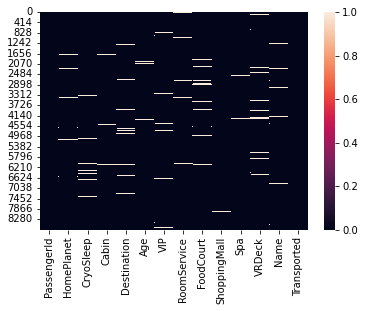

In [6]:
_= sns.heatmap(train.isnull())

In [7]:
train.isnull().mean() * 100

PassengerId     0.000000
HomePlanet      2.312205
CryoSleep       2.496261
Cabin           2.289198
Destination     2.093639
Age             2.059128
VIP             2.335212
RoomService     2.082135
FoodCourt       2.105142
ShoppingMall    2.392730
Spa             2.105142
VRDeck          2.162660
Name            2.300702
Transported     0.000000
dtype: float64

In [8]:
# 만약 하나라도 결측치를 갖는 행을 모두 삭제한다면, 남은 데이터 shape은?
(len(train) - len(train.dropna(how = 'any'))), len(train.dropna(how = 'any'))*100/len(train)

(2087, 75.99217761417232)

In [9]:
test.isnull().sum()

PassengerId       0
HomePlanet       87
CryoSleep        93
Cabin           100
Destination      92
Age              91
VIP              93
RoomService      82
FoodCourt       106
ShoppingMall     98
Spa             101
VRDeck           80
Name             94
dtype: int64

In [12]:
# 위 기술통계에서 Gollux Reedall 이름을 가진 사람이 2명으로 나타남.
# 중복값 확인 후 필요시 제거
train.duplicated().sum(), test.duplicated().sum()

(0, 0)

#### 기술통계 확인

In [10]:
train.describe()

,Age,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck
count,8514.000000,8512.000000,8510.000000,8485.000000,8510.000000,8505.000000
mean,28.827930,224.687617,458.077203,173.729169,311.138778,304.854791
std,14.489021,666.717663,1611.489240,604.696458,1136.705535,1145.717189
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,19.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,27.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,38.000000,47.000000,76.000000,27.000000,59.000000,46.000000
max,79.000000,14327.000000,29813.000000,23492.000000,22408.000000,24133.000000


In [11]:
train.describe(include = ['O'])

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,VIP,Name
count,8693,8492,8476,8494,8511,8490,8493
unique,8693,3,2,6560,3,2,8473
top,0001_01,Earth,False,G/734/S,TRAPPIST-1e,False,Gollux Reedall
freq,1,4602,5439,8,5915,8291,2


In [13]:
# 그럼 Gollux Reedall 샘플만 살짝 확인하고 넘어가자 - 그냥 우연히 이름이 같았나 봄
train[train['Name'] == 'Gollux Reedall']

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported
827,0881_01,Europa,False,D/32/S,TRAPPIST-1e,41.0,False,3103.0,3.0,0.0,31.0,26.0,Gollux Reedall,False
2852,3081_01,Europa,False,C/118/S,55 Cancri e,50.0,False,0.0,1547.0,0.0,1784.0,1.0,Gollux Reedall,True


#### 데이터 분포 확인

In [33]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8693 entries, 0 to 8692
Data columns (total 14 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   PassengerId   8693 non-null   object 
 1   HomePlanet    8492 non-null   object 
 2   CryoSleep     8476 non-null   object 
 3   Cabin         8494 non-null   object 
 4   Destination   8511 non-null   object 
 5   Age           8514 non-null   float64
 6   VIP           8490 non-null   object 
 7   RoomService   8512 non-null   float64
 8   FoodCourt     8510 non-null   float64
 9   ShoppingMall  8485 non-null   float64
 10  Spa           8510 non-null   float64
 11  VRDeck        8505 non-null   float64
 12  Name          8493 non-null   object 
 13  Transported   8693 non-null   bool   
dtypes: bool(1), float64(6), object(7)
memory usage: 891.5+ KB


In [41]:
# 범주형 변수 unique value 확인
obj_col = train.select_dtypes(include = 'object').columns.tolist()
train[obj_col].nunique()

PassengerId    8693
HomePlanet        3
CryoSleep         2
Cabin          6560
Destination       3
VIP               2
Name           8473
dtype: int64

In [45]:
print(train['HomePlanet'].unique())
print(train['CryoSleep'].unique())
print(train['Destination'].unique())
print(train['VIP'].unique())

['Europa' 'Earth' 'Mars' nan]
[False True nan]
['TRAPPIST-1e' 'PSO J318.5-22' '55 Cancri e' nan]
[False True nan]


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7febee527250>,
      dtype=object)

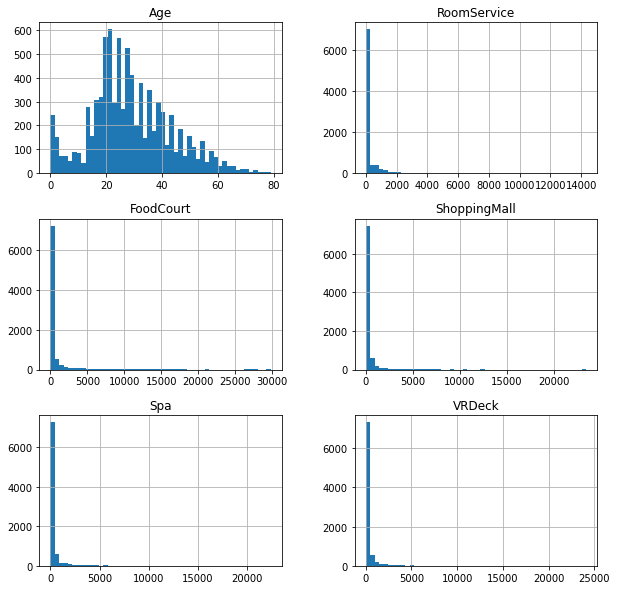

In [14]:
# 데이터 히스토그램 분포 확인 - 연속형/범주형 데이터 예상해보자
train.hist(bins = 50, figsize = (10,10))


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7febedf1b550>,
      dtype=object)

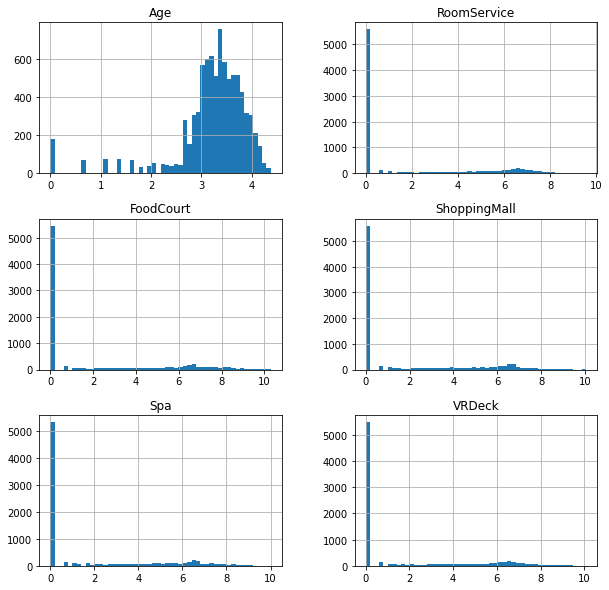

In [15]:
np.log1p(train.select_dtypes(include = 'number')).hist(bins = 50, figsize = (10,10))

위 히스토그램에서, 어메니티 지불 여부를 나타내는 5개 feature data가 분포 자체도 Imbalanced하고 scale이 너무 다름을 알 수 있음. <br>
일단 로그를 취했을 때, 위처럼 Scale이 비슷하고 분포도 정규분포처럼 가운데 산을 기준으로 좌우가 대칭에 비슷해진 형태를 보임.<br>
하지만 여전히 어메니티를 이용하지 않는 고객의 비율이 너무 높아 데이터가 imbalanced함. <br>얘는 예측값이 아니라 feature extraction에 사용될 원본 feature 중 하나일 뿐인데. under/oversampling을 통한 평탄화 작업이 필요할까? <br>이걸 알아보기 위해, 각 데이터가 0의 값을 가질 때 Transported 비율이 어떻게 되는지를 확인해봐야겠음.

In [48]:
train.Transported.value_counts()

True     4378
False    4315
Name: Transported, dtype: int64

### 2.2. 가설 확인을 위한 데이터 EDA


In [46]:
train.head(3)

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported
0,0001_01,Europa,False,B/0/P,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,Maham Ofracculy,False
1,0002_01,Earth,False,F/0/S,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,Juanna Vines,True
2,0003_01,Europa,False,A/0/S,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0,Altark Susent,False


#### 가설1. VIP는 Transport될 확률이 낮다
    - 구조대원들은 VIP를 우선으로 구출한다 
    - 따라서 VIP는 Transported될 확률이 낮을 것이다

In [51]:
# VIP 비율 - 일반 승객 대비 매우 소수
train.VIP.value_counts(normalize = True)*100

False    97.656066
True      2.343934
Name: VIP, dtype: float64

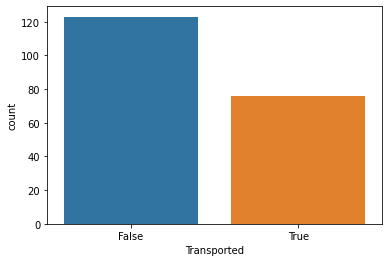

In [57]:
_ = sns.countplot(data = train[train.VIP == True], x = 'Transported',)

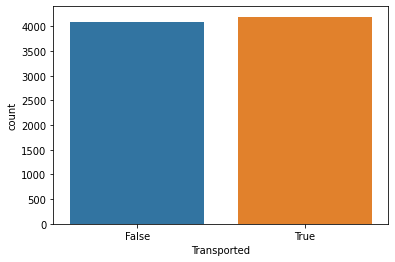

In [58]:
_ = sns.countplot(data = train[train.VIP == False], x = 'Transported',)

VIP == True일 때, Transported된 비율이 약 30% 정도 낮은 반면<br>
VIP == False일 땐, 비슷한 확률로 Transported되었음을 알 수 있다<br>
이를 통해 1번의 가설처럼, VIP가 Transported를 결정하는데 중요한 feature로 작용함을 확인할 수 있었음.

추가로 VIP와 관련있는 다른 featur는 무엇이 있는지 알아보기 위해, 기존의 column으로부터 새로운 feature를 extract해서 관계를 알아봄.

###### 1) VIP - HomePlanet/Destination


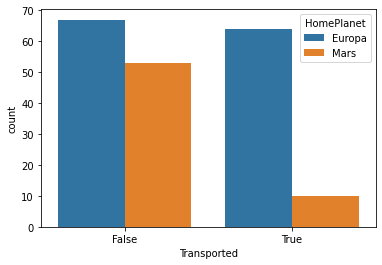

In [54]:
_ = sns.countplot(data = train[train.VIP == True], x = 'Transported', hue = 'HomePlanet')

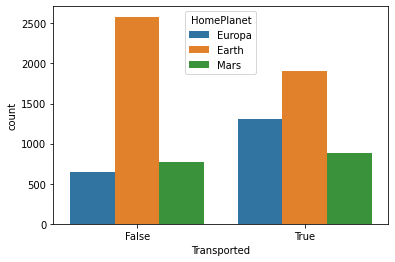

In [56]:
_ = sns.countplot(data = train[train.VIP == False], x = 'Transported', hue = 'HomePlanet')

###### 2) VIP - CryoSleep

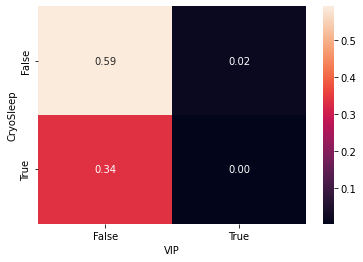

In [67]:

_ = sns.heatmap(pd.crosstab(index = train.CryoSleep, columns = train.VIP)/len(train), annot = True, fmt = ',.2f' )


In [71]:
round(train.loc[train.VIP == True, 'CryoSleep'].value_counts(normalize = True)*100,3)

False   89.28600
True    10.71400
Name: CryoSleep, dtype: float64

###### 3) VIP - Age

###### 4) VIP - RoomService/FoodCourt/ShoppingMall/Spa/VRDeck	

#### 가설2. FC/SM/Spa/VRDeck 이용 승객들은 Transport될 확률이 낮다
    - 구조대원들은 (객실에 있는 승객을 밖으로 불러내는 동안) 외부에 머무르던 승객들을 우선으로 구출한다
    - 따라서 객실 밖에 머무르고 있을 확률이 큰 FoodCourt/ShoppingMall/Spa/VRDeck 지불 고객들은 Transport 확률이 낮다
    - 반대로 객실에서 이용하는 RoomService 이용 고객은 Transport 확률이 높다

###### 어메니티 이용X 승객 - feature 별 Transported 분포

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


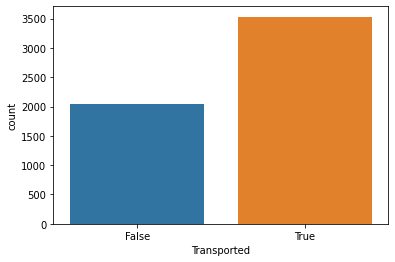

In [17]:
_ = sns.countplot(train.loc[train['RoomService']==0, 'Transported'])

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


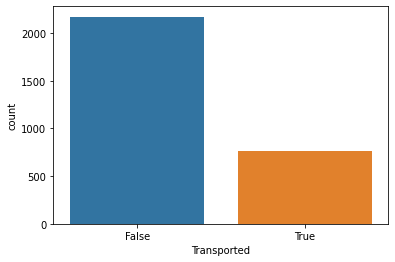

In [22]:
_ = sns.countplot(train.loc[train['RoomService']>0, 'Transported'])

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


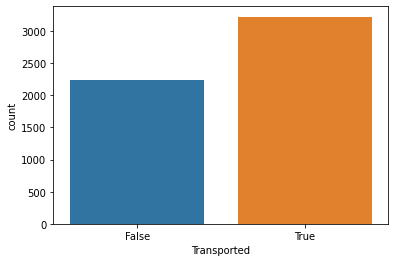

In [18]:
_ = sns.countplot(train.loc[train['FoodCourt']==0, 'Transported'])

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


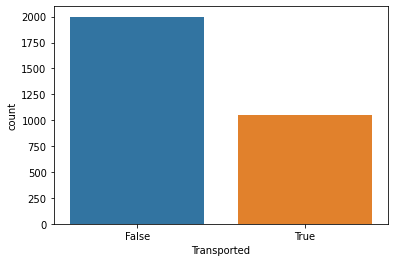

In [29]:
_ = sns.countplot(train.loc[train['FoodCourt']>0, 'Transported'])

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


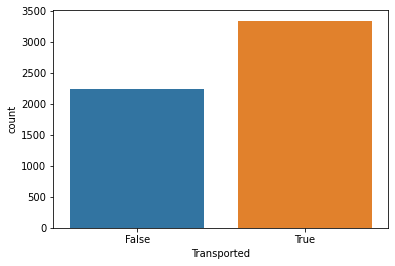

In [19]:
_ = sns.countplot(train.loc[train['ShoppingMall']==0, 'Transported'])

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


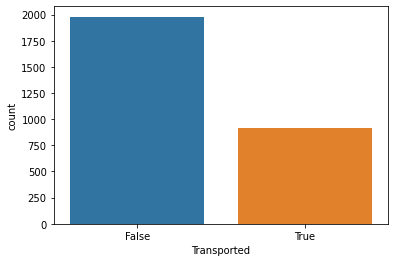

In [28]:
_ = sns.countplot(train.loc[train['ShoppingMall']>0, 'Transported'])

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


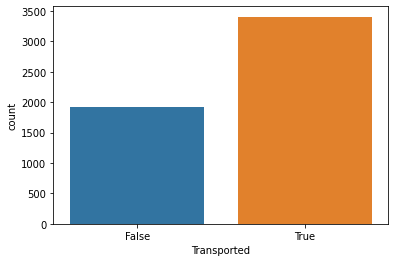

In [20]:
_ = sns.countplot(train.loc[train['Spa']==0, 'Transported'])

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


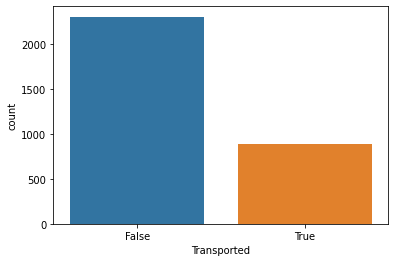

In [27]:
_ = sns.countplot(train.loc[train['Spa']>0, 'Transported'])

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


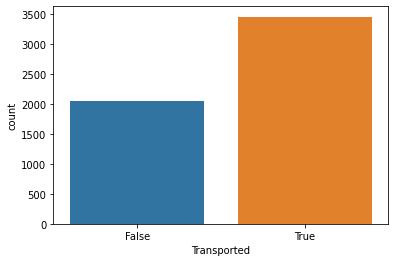

In [21]:
_ = sns.countplot(train.loc[train['VRDeck']==0, 'Transported'])

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


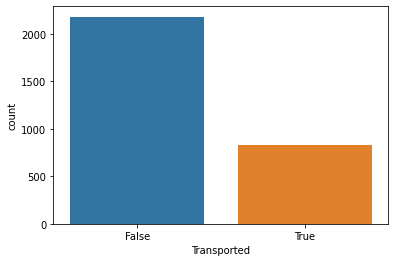

In [26]:
_ = sns.countplot(train.loc[train['VRDeck']>0, 'Transported'])

#### 가설3. Name, PassengerId feature는 Transport 여부와 관계가 있다
    - Last name이 같으면 가족이다 / 가족단위 승객들은 서로를 도우면서 구출될 확률이 높아진다 
    - 따라서 승객들 중 동일한 Last name을 가진 사람이 존재하면, Transported 확률이 낮다

#### 가설4. HomePlanet/Destination은 Transport 여부와 영향이 없다
    -  출발/도착행성은 Cabin 배정과 관련이 없다. 따라서 확률적인 영향이 없다 

#### 가설5.Cryosleep 이용자는 Transport될 확률이 높다 
    - Cryosleep에 해당하는 승객들은, 위기상황을 인지하고 적극적으로 도움을 청하기가 어려우므로 구출될 확률이 낮다
    - 따라서 Cryosleep 승객은 Transported될 확률이 높을 것이다


#### 가설6. Age가 어리면 Transport될 확률이 낮다 
    - 나이가 어린 승객은 우선으로 구출한다
    - 따라서 Age가 낮으면 Transported될 확률도 낮고, 양의 상관관계를 가질 것이다